## 外卖订单的评论分析

---

### 介绍

通过前八个实验的学习，相信同学们对于自然语言处理有了一定的认知，包括如何读取文本、如何处理文本数据、如何表征文本等，那么如何将这些知识应用于实战呢？本实验将通过案例“外卖订单的评论分析”，带领大家巩固基础知识以及熟悉文本分类的基本流程。

#### 知识点

- 数据分析
- 数据预处理
- 模型训练及后续优化

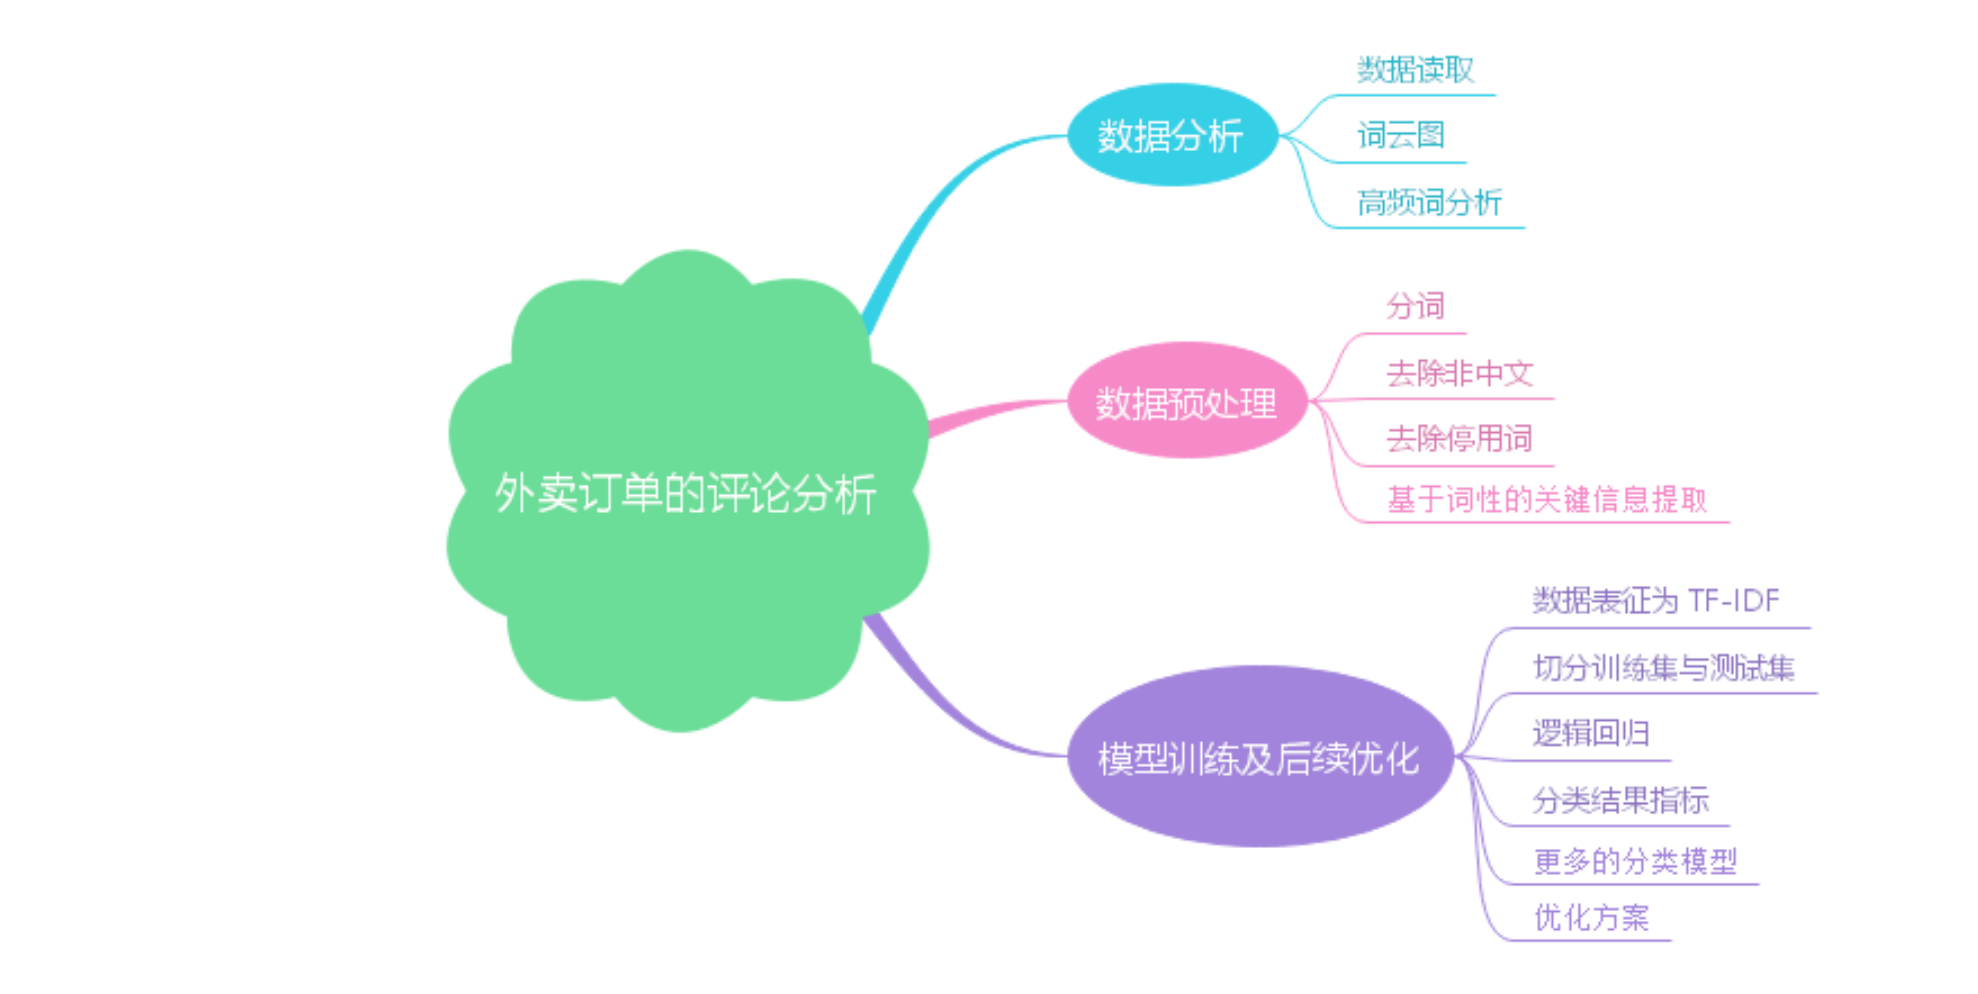

### 数据分析

随着外卖平台的成熟以及物流业的快速发展，点外卖已成为大部分中国人的日常活动之一。虽然顾客与店家之间并无直接接触，但是平台的实时评论打分机制能够有力地监督店家，保障顾客权益。另一方面，这些外卖评论也为商家或平台提供了大量文本数据，如果利用得当，将是一笔宝贵的数据资源。例如，商家通过分析外卖评论，可以获取某地区用户的口味偏好、差评好评的侧重点等，以及时调整发送菜品；而平台通过大量外卖分析，也可以从宏观的角度分析不同年龄段、不同地区、不同工种民众的饮食习惯，为商业决策提供信息。

本实验中有一批外卖订单的评论，主要分为正面评论以及负面评论，本文的任务主要有二：

- 分析外卖订单的文本数据，挖掘有用信息。
- 根据数据训练一个外卖评论的自动分类器，能够将评论自动归类为正面或负面评论。

首先读取文本，熟悉数据格式。

<i class="fa fa-arrow-circle-down" aria-hidden="true"> 教学代码：</i>

In [ ]:
import pandas as pd
# 读取外卖数据
waimai_data = pd.read_csv(
    'https://labfile.oss.aliyuncs.com/courses/3205/waimai_10k.csv')
waimai_data.head(10)  # 第一列 label 为标签，为 1 或 0，第二列 review 为评论内容

<i class="fa fa-arrow-circle-down" aria-hidden="true"> 动手练习:</i>

接下来对文本数据进行一系列分析，包括所有文本及正负样本的词云图，正负样本的高频词统计分析，对数据概况进行宏观表示。

In [ ]:
!pip install WordCloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

!wget -nc 'https://labfile.oss.aliyuncs.com/courses/3205/simkai.ttf'
def show_wordcloud(allwords):
    # 文本数据以词云形式进行可视化
    # allwords 是已分好词的字符串形式，如“我 喜欢 吃 土豆”
    # 由于 WordCloud 没有现成的针对中文的字体，这里需要先下载中文字体文件并将路径添加到 font_path 参数中，
    # 这里已经下载至线上环境
    wordcloud = WordCloud(font_path='simkai.ttf',
                          width=800, height=500, random_state=21, max_font_size=110).generate(allwords)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

所有文本形成的词云，词汇越大，说明词频越高：

In [ ]:
import jieba
all_review_words = ' '.join([' '.join(jieba.lcut(text))
                             for text in waimai_data['review']])
show_wordcloud(all_review_words)

从直观上感受，外卖评论主要的关注点集中于口味、送餐速度，其次是服务态度、份量、包装、价格等，并且比较有用的关键词多是动词、形容词以及名词，当然也存在很多无意义的高频词，比如“的”、“了”。

所有正样本形成的词云：

In [ ]:
review_words_pos = ' '.join([' '.join(jieba.lcut(text))
                             for text in waimai_data['review'][waimai_data['label'] == 1]])
show_wordcloud(review_words_pos)

从大体上看，正面评论主要是要表达“味道好吃”、“送餐速度快”、“感谢外卖员”、“服务态度好”这些方面。

所有负样本形成的词云：

In [ ]:
review_words_neg = ' '.join([' '.join(jieba.lcut(text))
                             for text in waimai_data['review'][waimai_data['label'] == 0]])
all_review_words
show_wordcloud(review_words_neg)

从大体上看，负面评论主要是要表达“味道难吃”、“送餐速度慢”这俩方面。另外 ，还存在许多否定词，比如“还是”、“一点”、“不是”、“不”、“没有”。一个有趣的现象是，不管是正面还是负面评论中，“好吃”都是一个高频词，筛选负面评论中含有“好吃”的文本一探究竟。

In [ ]:
# 获取负面评论中含有“好吃”的文本
texts_neg_with_haochi = [text for text in waimai_data['review']
                         [waimai_data['label'] == 0] if "好吃" in text]
texts_neg_with_haochi

In [ ]:
通过一些文本的观察可知，“好吃”一般与一些否定词相搭配，形成否定的负面意思，比如“没有以前好吃”，“不好吃”，“不太好吃”，“不是特别好吃”等表达。

In [ ]:
在有了一定的感性认识之后，接下来对词汇作一些定量分析，分别统计出正/负面评价的词频，观察两类文本中高低频词的特性，以便作更进一步的文本预处理操作。

统计正样本的词频：

In [ ]:
from collections import Counter

waimai_data['review_cuted'] = waimai_data['review'].apply(
    lambda x: jieba.lcut(x))  # 对文本进行分词处理，作为新的一列
words_pos = Counter([i for j in waimai_data['review_cuted']
                     [waimai_data['label'] == 1] for i in j])  # 统计词频
# 观察 top20 的高频词以及低频词
print("正样本top20 高频词：\n", words_pos.most_common(20))
print("正样本top20 低频词：\n", words_pos.most_common()[:-20:-1])

统计负样本的词频：

In [ ]:
words_neg = Counter([i for j in waimai_data['review_cuted']
                     [waimai_data['label'] == 0] for i in j])
# 观察 top20 的高频词以及低频词
print("负样本top20 高频词：\n", words_neg.most_common(20))
print("负样本top20 低频词：\n", words_neg.most_common()[:-20:-1])

通过以上的高低频词的打印结果，我们可以观察并分析出两个结论：

In [ ]:
- 正负样本中的高频词中存在一些共同的词汇，比如“了”、“的”、“也”以及一些标点符号，因此理论上这些符号不存在区分度，可以作为停用词去除。
- 大部分低频词从直观上感受，与正负面情感无直接关联，因此理论上也可以把出现次数为 1 的词汇均作为停用词去除。

基于以上逻辑，我们构建一份停用词表。

In [ ]:
# 取正负样本中 top20 的共同词汇
high_freq_stopwords = list(set([i[0] for i in words_pos.most_common(
    20)]).intersection(set([i[0] for i in words_neg.most_common(20)])))
# 取出现次数为 1 的词汇
low_freq_stopwords = [k for k, v in Counter(
    [i for j in waimai_data['review_cuted'] for i in j]).items() if v == 1]
stopwords = set(high_freq_stopwords + low_freq_stopwords)

### 数据预处理

接下来对数据尝试多种预处理方式，主要包括：

- 原文本
- 只保留文本中的中文
- 去除停用词
- 只保留文本中特定词性的词汇

原文本分词处理：

In [ ]:
waimai_data["review_cuted_word"] = waimai_data["review"].apply(
    lambda x: " ".join([i for i in jieba.lcut(x)]))

对于每条评论，去除非中文字符并且分词：

In [ ]:
import re

waimai_data["review_keep_chinese"] = waimai_data["review"].apply(
    lambda x: " ".join(jieba.lcut(re.sub("[^\u4e00-\u9fa5]", "", x))))

停用词过滤：

In [ ]:
waimai_data["review_delete_stopwords"] = waimai_data["review"].apply(
    lambda x: " ".join([i for i in jieba.lcut(x) if i not in stopwords]))

只保留某些词性的词汇：

In [ ]:
import jieba.posseg as posseg
import numpy as np


def keep_important_pos(input_text):
    # 重要的词性，包括形、动、名以及一些否定副词
    pos_pattern = ("a", "v", "n", "ad", "an", "d",
                   "vg", "vd", "vn", "m", "u", "c")
    output_text = " ".join(
        [i.word for i in jieba.posseg.cut(input_text) if i.flag in pos_pattern])
    return output_text


# 对 waimai_data["review"] 中的每一个文本进行函数 keep_important_pos() 的处理
waimai_data["review_keep_word_by_pos"] = np.vectorize(
    keep_important_pos)(waimai_data["review"])

所有数据如下：

In [ ]:
waimai_data

### 模型训练及后续优化

在完成对数据的多种预处理之后，接下来调用机器学习集成库 scikit-learn 中的模型进行分类训练：

- 应用同一模型对不同处理之后的数据进行训练，看哪一种预处理方式最佳；
- 固定预处理数据，尝试应用多种模型，对比得到最好效果的模型。

首先，由于原始数据的标签存在固定顺序，对数据随机打乱顺序：

In [ ]:
from sklearn.utils import shuffle
# random_state 相当于随机数种子，使得随机打乱后的数据一样，为了第三人复现代码结果
waimai_data_shuffled = shuffle(waimai_data, random_state=0)

将文本转换为 TF-IDF 形式：

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


def text2tfidf(data):
    # data 为输入的文本数据
    tfidf_vectorizer = TfidfVectorizer().fit_transform(data)
    return tfidf_vectorizer

将数据切分为训练集与测试集：

In [ ]:
def split_train_test(X, y, train_frac=0.8):
    # X 为输入数据,y 为标签,train_frac 为训练数据量占比
    train_test_bound = int(len(y)*train_frac)
    X_train, y_train = X[:train_test_bound,
                         :], y[:train_test_bound]  # 测试文本及其标签
    X_test, y_test = X[train_test_bound:, :], y[train_test_bound:]  # 训练文本及其标签
    return X_train, y_train, X_test, y_test

模型训练并输出测试结果：

In [ ]:
from sklearn.metrics import classification_report


def train_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)  # 使用训练集进行训练
    y_predict = model.predict(X_test)  # 使用训练好的模型对测试集进行预测
    print('accuracy:%f' % model.score(X_test, y_test))  # 获得模型在测试集上的准确率
    print(classification_report(y_test, y_predict,
                                target_names=['负面评论', '正负评论']))  # 综合测试报告

综合以上过程的主函数：

In [ ]:
def main(X_ori, y, model, train_frac=0.8):
    # X_ori 表示文本，y 表示标签, model 表示模型
    tfidf_X = text2tfidf(X_ori)  # 将文本转化为 TFIDF 特征
    X_train, y_train, X_test, y_test = split_train_test(
        tfidf_X, y, train_frac)  # 训练集测试集切分
    train_model(model, X_train, y_train, X_test, y_test)  # 模型训练及评估

各数据统计均应用逻辑回归进行训练，作对比：

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
y = waimai_data_shuffled["label"]
print("原文本:\n")
main(waimai_data_shuffled["review_cuted_word"], y, lr)
print("只保留文本中的中文:\n")
main(waimai_data_shuffled["review_keep_chinese"], y, lr)
print("去除停用词:\n")
main(waimai_data_shuffled["review_delete_stopwords"], y, lr)
print("只保留文本中特定词性的词汇:\n")
main(waimai_data_shuffled["review_keep_word_by_pos"], y, lr)

在这里，对以上结果中的评价指标作简单介绍，首先观察如下表格（称为混淆矩阵）：

|        | 预测值为正  | 预测值为负
|  ----  | ----  |----  |
| 真实值为正  | TP |FN |
| 真实值为负  | FP |TN |

注意，这里的正例并非指正面评论，而负例并非指负面评论，以上表格是针对每一个类别而言。在我们的案例中，有两个类别，正面评论以及负面评论，针对每一个类别都有一个对应的混淆矩阵，因此对于每个类别，都有对应的指标。

根据预测值与真实值的不同，分类结果可分为四大情况：

- TP(True positives)：实际为正例且被分类器划分为正例的样本数，例如某样本真实情况为正面评论且分类器也预测其为正面评论。
- FN(False positives)：实际为正例但被分类器划分为负例的样本数。
- FP(False negatives)：实际为负例但被分类器划分为正例的样本数。
- TN(True negatives)：实际为负例且被分类器划分为负例的样本数。

基于以上四大情况，accuracy、precision、recall、F1 定义如下：

- accuracy：$\frac{TP+TN}{P+N}$，即预测正确的数量除以样本总数量。
- precision：$\frac{TP}{TP+FP}$，即正确地预测为正例的数量除以预测为正例的总数。
- recall：$\frac{TP}{TP+FN}$，即正确地预测为正例的数量除以实际为正例的总数。
- F1：precision 与 recall 之间的综合考量，两者结合的评估指标，$\frac{2*precision*recall}{precision+recall}$。

注意，一般把 accuracy 译为准确率或正确率，precision 译为精确率或精准率或查准率，在中文中这些词汇含义容易混淆，因此最好使用英文，方便记忆。

最后来看 Micro-F1 和 Macro-F1，是针对所有类的综合考量：

- Micro-F1：指上述结果中的 micro avg，先计算出所有类别总的 precision 和 recall，然后计算出的 f1 即为 Micro-F1。
- Macro-F1：指上述结果中的 macro avg，计算出每一个类别的 precison 和 recall 后计算 f1，最后将 f1 平均即为 Macro-F1。

除了以上模型评价指标，实际上还有 ROC 曲线、AUC 面积等指标，那么这么多指标，到底以谁为准，如何综合判断呢？比如，我们关注评论分类器的整体判别能力，那么可以以 accuracy 或者 F1为主；希望把评论中的差评尽可能地找出来，那么需要更关注差评的 recall；希望预测为差评的样本别出错就行了，那么更关注差评的 precision。这其实取决于相关的场景以及具体的任务倾向性，不能一概而论。

由以上结果可知，只保留文本中的中文以及去除停用词结果稍好一些，在只保留某些词性的词汇时，效果反而变差，由此可见，切忌基于主观上的推理做一些盲目的文本预处理工作，预处理的有效性需要基于结果来对比证实。接下来，我们只保留文本中的中文作为训练数据，应用多种模型进行分类尝试，分别为：

- 支持向量机
- 朴素贝叶斯
- GBDT
- 感知机

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Perceptron

svm = LinearSVC()   # 初始化支持向量机
naive_bayes = MultinomialNB()   # 初始化朴素贝叶斯
gbdt = GradientBoostingClassifier()   # 初始化 GBDT
perceptron = Perceptron()   # 初始化感知机
X = waimai_data_shuffled["review_keep_chinese"]
y = waimai_data_shuffled["label"]
print("支持向量机:\n")
main(X, y, svm)
print("朴素贝叶斯:\n")
main(X, y, naive_bayes)
print("GBDT:\n")
main(X, y, gbdt)
print("感知机:\n")
main(X, y, perceptron)

由以上结果可知，支持向量机比逻辑回归效果稍优，其它模型反而效果下降。那么，还有后续的优化空间吗？答案是肯定的。同学们可以从以下几方面入手尝试更多的优化：

- 数据增强
- 改变数据的表征形式
- 机器学习模型调参
- 深度学习模型

### 实验总结

有了一些理论基础后，实战是提高能力的最有效途径，本实验综合性较强，有利于巩固大家的基础知识以及对文本分析的流程有一个概括性的认知，主要涉及到了以下知识点：

- 数据分析
- 数据预处理
- 模型训练及后续优化

在下一实验中，我们将学习人工智能中一个非常有趣的应用，如何搭建一个对话系统。

<hr><div style="color: #999; font-size: 12px;"><i class="fa fa-copyright" aria-hidden="true"> 本课程内容版权归蓝桥云课所有，禁止转载、下载及非法传播。</i></div>